<a href="https://colab.research.google.com/github/jenmacena19/recomendacaoReceitas/blob/main/SistemaDeReceitas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Material de estudo baseado nos dados disponibilizados na plataforma Kaggle
https://www.kaggle.com/code/leaponalex/starter-food-com-recipes-and-4225ec01-e/notebook

# Importar dataset

In [1]:
! pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
! mkdir ~/.kaggle

In [3]:
! chmod 600 ~/.kaggle/kaggle.json

chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [4]:
! cp kaggle.json ~/.kaggle/

cp: cannot stat 'kaggle.json': No such file or directory


In [5]:
! chmod 600 /root/.kaggle/kaggle.json

chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [6]:
!kaggle kernels output leaponalex/starter-food-com-recipes-and-4225ec01-e -p /path/to/dest

Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python3.7/dist-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/usr/local/lib/python3.7/dist-packages/kaggle/api/kaggle_api_extended.py", line 166, in authenticate
    self.config_file, self.config_dir))
OSError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method.


In [7]:
! kaggle datasets list

Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python3.7/dist-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/usr/local/lib/python3.7/dist-packages/kaggle/api/kaggle_api_extended.py", line 166, in authenticate
    self.config_file, self.config_dir))
OSError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method.


# Tratamento do dataset

In [8]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt # plotting
import numpy as np # linear algebra
import os # accessing directory structure
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
# Correlation matrix
def plotCorrelationMatrix(df, graphWidth):
    filename = df.dataframeName
    df = df.dropna('columns') # drop columns with NaN
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    if df.shape[1] < 2:
        print(f'No correlation plots shown: The number of non-NaN or constant columns ({df.shape[1]}) is less than 2')
        return
    corr = df.corr()
    plt.figure(num=None, figsize=(graphWidth, graphWidth), dpi=80, facecolor='w', edgecolor='k')
    corrMat = plt.matshow(corr, fignum = 1)
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.columns)), corr.columns)
    plt.gca().xaxis.tick_bottom()
    plt.colorbar(corrMat)
    plt.title(f'Correlation Matrix for {filename}', fontsize=15)
    plt.show()

In [13]:
nRowsRead = 1000 # specify 'None' if want to read whole file
# interactions_test.csv has 12455 rows in reality, but we are only loading/previewing the first 1000 rows
df1 = pd.read_csv('./drive/MyDrive/Dataset/RAW_recipes.csv', delimiter=',', nrows = nRowsRead)
df1.dataframeName = 'RAW_recipes.csv'
nRow, nCol = df1.shape
print(f'There are {nRow} rows and {nCol} columns')

There are 1000 rows and 12 columns


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.dropna will be keyword-only
  after removing the cwd from sys.path.


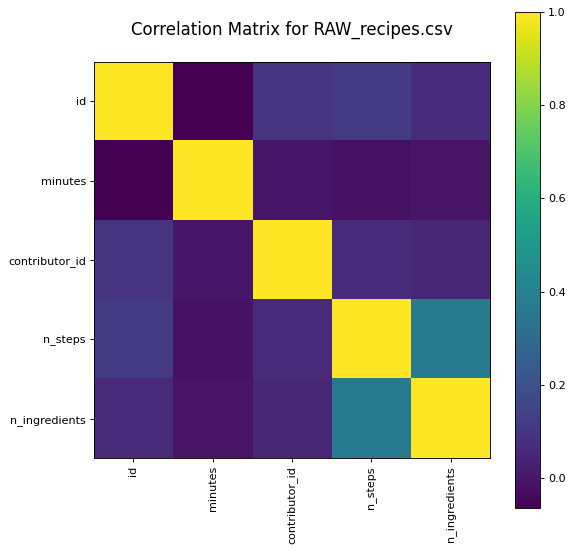

In [14]:
plotCorrelationMatrix(df1, 8)

In [16]:
nRowsRead = 1000 # specify 'None' if want to read whole file
# interactions_train.csv has 698901 rows in reality, but we are only loading/previewing the first 1000 rows
df2 = pd.read_csv('./drive/MyDrive/Dataset/interactions_train.csv', delimiter=',', nrows = nRowsRead)
df2.dataframeName = 'interactions_train.csv'
nRow, nCol = df2.shape
print(f'There are {nRow} rows and {nCol} columns')

There are 1000 rows and 6 columns


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.dropna will be keyword-only
  after removing the cwd from sys.path.


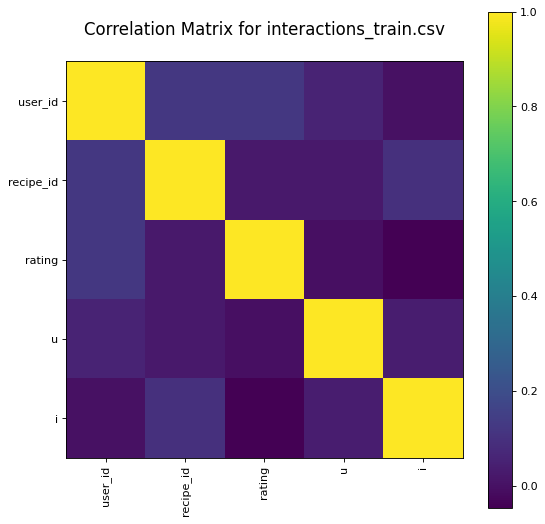

In [17]:
plotCorrelationMatrix(df2, 8)

In [18]:
df2.head(5)

# users = {id_user: [receitas_id, nome_receita] rating
# manhatan = as receitas mais similares

,user_id,recipe_id,date,rating,u,i
0,2046,4684,2000-02-25,5.0,22095,44367
1,2046,517,2000-02-25,5.0,22095,87844
2,1773,7435,2000-03-13,5.0,24732,138181
3,1773,278,2000-03-13,4.0,24732,93054
4,2046,3431,2000-04-07,5.0,22095,101723


In [ ]:
def manhattan(vector1, vector2):
        """Computes the Manhattan distance."""
        distance = 0
        total = 0
        n = len(vector1)
        for i in range(n):
                distance += abs(vector1[i] - vector2[i])
        return distance

def computeNearestNeighbor(itemName, itemVector, items):
        """creates a sorted list of items based on their distance to item""" 
        distances = [] 
        for otherItem in items: 
                if otherItem != itemName: 
                        distance = manhattan(itemVector, items[otherItem]) 
                        distances.append((distance, otherItem)) 
        # sort based on distance -- closest first 
        distances.sort() 
        return distances
 
def classify(user, itemName, itemVector): 
         # first find nearest neighbor 
         nearest = computeNearestNeighbor(df2['recipe_id'][1], df2['rating'][1], [4, 2, 5]) 
         rating = users[user][nearest] 
         return rating


In [19]:
df1.head(5)

,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients
0,arriba baked winter squash mexican style,137739,55,47892,2005-09-16,"['60-minutes-or-less', 'time-to-make', 'course...","[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11,"['make a choice and proceed with recipe', 'dep...",autumn is my favorite time of year to cook! th...,"['winter squash', 'mexican seasoning', 'mixed ...",7
1,a bit different breakfast pizza,31490,30,26278,2002-06-17,"['30-minutes-or-less', 'time-to-make', 'course...","[173.4, 18.0, 0.0, 17.0, 22.0, 35.0, 1.0]",9,"['preheat oven to 425 degrees f', 'press dough...",this recipe calls for the crust to be prebaked...,"['prepared pizza crust', 'sausage patty', 'egg...",6
2,all in the kitchen chili,112140,130,196586,2005-02-25,"['time-to-make', 'course', 'preparation', 'mai...","[269.8, 22.0, 32.0, 48.0, 39.0, 27.0, 5.0]",6,"['brown ground beef in large pot', 'add choppe...",this modified version of 'mom's' chili was a h...,"['ground beef', 'yellow onions', 'diced tomato...",13
3,alouette potatoes,59389,45,68585,2003-04-14,"['60-minutes-or-less', 'time-to-make', 'course...","[368.1, 17.0, 10.0, 2.0, 14.0, 8.0, 20.0]",11,['place potatoes in a large pot of lightly sal...,"this is a super easy, great tasting, make ahea...","['spreadable cheese with garlic and herbs', 'n...",11
4,amish tomato ketchup for canning,44061,190,41706,2002-10-25,"['weeknight', 'time-to-make', 'course', 'main-...","[352.9, 1.0, 337.0, 23.0, 3.0, 0.0, 28.0]",5,['mix all ingredients& boil for 2 1 / 2 hours ...,my dh's amish mother raised him on this recipe...,"['tomato juice', 'apple cider vinegar', 'sugar...",8


In [20]:
df2.head(5)

,user_id,recipe_id,date,rating,u,i
0,2046,4684,2000-02-25,5.0,22095,44367
1,2046,517,2000-02-25,5.0,22095,87844
2,1773,7435,2000-03-13,5.0,24732,138181
3,1773,278,2000-03-13,4.0,24732,93054
4,2046,3431,2000-04-07,5.0,22095,101723


In [21]:
min_rating = df2['rating'].min()
max_rating = df2['rating'].max()
print("Menor valor de Rating", min_rating)
print("Maior valor de Rating", max_rating)

Menor valor de Rating 0.0
Maior valor de Rating 5.0


# Receitas mais populares

Aplicando TF-IDF para ver os termos mais relevantes no dataset de receitas


In [22]:
#Quais são os ingredientes mais populares?

ingredientes_populares = df1.ingredients.str.split(',').explode().value_counts().sort_values(ascending=False)
ingredientes_populares.head(10)

 'salt'             329
 'sugar'            166
 'butter'           152
 'onion'            149
 'water'            131
 'eggs'             125
 'flour'            100
 'milk'             100
 'garlic cloves'     94
 'brown sugar'       73
Name: ingredients, dtype: int64

In [23]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [24]:
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(df1['ingredients'])
tfidf_matrix.shape

(1000, 1076)

In [25]:
print("As n palavras extraídas",tfidf.get_feature_names_out())

As n palavras extraídas ['10' '15' '98' ... 'zest' 'ziti' 'zucchini']


In [26]:
print('Matriz Esparsa de TD-IDf')
pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf.get_feature_names(),   index=df1.name).sample(20, axis=1).sample(10, axis=0)


Matriz Esparsa de TD-IDf


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,veggie,chestnuts,limeade,salted,tortellini,chicken,creme,muesli,lump,leg,rose,loin,halves,mccormick,grain,bottled,navy,cheese,marsala,pimento
name,,,,,,,,,,,,,,,,,,,,
creamy chicken pot pie pies pot pies easy yummy,0.0,0.0,0.0,0.0,0.0,0.238088,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
elephant ear dutch baby,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
we re going bananas bread,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
three sisters stew,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15 minute chicken broccoli and rice dinner,0.0,0.0,0.0,0.0,0.0,0.367725,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1 2 cup soup,0.0,0.0,0.0,0.0,0.0,0.281040,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
clean out the fridge soup,0.0,0.0,0.0,0.0,0.0,0.132846,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1 pot curried rotini with currants peas and red peppers,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13 crackers meatloaf,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Similaridade das Receitas Culinárias 

A partir da Matriz esparsa obtida, foi calculado a Similaridade de Cosseno. Assim, será calculado a similaridade entre os itens (receitas).

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
cosine_sim = cosine_similarity(tfidf_matrix)

In [ ]:
cosine_sim_df = pd.DataFrame(cosine_sim, index=df1['name'], columns=df1['name'])
print('Shape:', cosine_sim_df.shape)
cosine_sim_df.sample(5, axis=1).round(2)

In [ ]:
def genre_recommendations(i, M, items, k=10):
    """
    Recomenda filmes baseados em um dataframe de similaridade

    Parâmetros
    ----------
    i : string
        Filme Alvo (índice do dataframe de similaridade)
    M : pd.DataFrame
        Dataframe de similaridade, simétrico, com filmes como índices e colunas
    items : pd.DataFrame
        Contém tanto o título quanto gênero usados para definir semelhança
    k : int
        Quantidade de recomendações para retornar

    """

    """ obtem uma lista de índices dos filmes mais similares ao filme alvo """
    """ por meio do argpartition pegamos os índices do k valores mais altos na
    (matriz de similaridade) para um filme alvo (i)"""
    ix = M.loc[:,i].to_numpy().argpartition(range(-1,-k,-1))   

    """ obtem a lista de nomes dos k filmes mais similares de similaridade mais alta
     para os de similaridade mais baixa, incluindo a similaridade do filme alvo """
    closest = M.columns[ix[-1:-(k+2):-1]]
   
    """ deleta o filme alvo como parametro da lista de filmes mais similares """
    closest = closest.drop(i, errors='ignore')

    """ retorna a lista com os nomes de k filmes mais similares """

    return pd.DataFrame(closest).merge(items).head(k)

# Teste Recomendação

In [ ]:
# receitas que tem 6 passos/etapas
df1[df1.n_steps.eq(6)]

,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients
2,all in the kitchen chili,112140,130,196586,2005-02-25,"['time-to-make', 'course', 'preparation', 'mai...","[269.8, 22.0, 32.0, 48.0, 39.0, 27.0, 5.0]",6,"['brown ground beef in large pot', 'add choppe...",this modified version of 'mom's' chili was a h...,"['ground beef', 'yellow onions', 'diced tomato...",13
14,calm your nerves tonic,39959,5,37449,2002-09-10,"['15-minutes-or-less', 'time-to-make', 'prepar...","[8.2, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0]",6,"['combine herbs', 'dosage: one-half teaspoonfu...",this will prove a blessing to everyone who tak...,"['gentian root', 'scullcap herb', 'burnet root...",5
35,homemade vegetable soup from a can,87098,12,70662,2004-03-20,"['15-minutes-or-less', 'time-to-make', 'course...","[276.2, 3.0, 55.0, 18.0, 23.0, 2.0, 20.0]",6,"['combine all ingredients in large pot', 'brin...",my friend just made this for dinner the other ...,"['low sodium chicken broth', 'diced tomatoes',...",8
39,i don t feel like cooking tonight casserole,22123,45,34687,2002-03-11,"['60-minutes-or-less', 'time-to-make', 'course...","[647.6, 57.0, 57.0, 58.0, 54.0, 53.0, 16.0]",6,"['brown onion and meat in the oil , drain any ...",this is a hearty and filling casserole for tho...,"['ground beef', 'onion', 'frozen vegetables', ...",8
43,immoral sandwich filling loose meat,58224,35,37183,2003-04-04,"['60-minutes-or-less', 'time-to-make', 'course...","[223.2, 22.0, 4.0, 7.0, 35.0, 30.0, 0.0]",6,"['brown the meat & drain fat', 'stir in sugar ...",just the thing for a day when you're wanton so...,"['ground beef', 'sugar', 'prepared yellow must...",8
...,...,...,...,...,...,...,...,...,...,...,...,...
977,15 bean soup,311608,370,196248,2008-07-02,"['ham', 'course', 'main-ingredient', 'preparat...","[49.4, 0.0, 21.0, 20.0, 3.0, 0.0, 3.0]",6,"['presoak beans overnight , or boil them accor...","i like bean soups since they're cheap, easy to...","['15 bean mix', 'tomato sauce', 'ham hocks', '...",13
979,15 minute chicken liver pate,237391,15,316097,2007-06-27,"['15-minutes-or-less', 'time-to-make', 'course...","[194.9, 24.0, 2.0, 13.0, 16.0, 46.0, 0.0]",6,['cook onion and garlic in 1 tbsp of the butte...,who says sophisticated hors d'oeuvres have to ...,"['chicken liver', 'onion', 'garlic clove', 'bu...",11
983,15 minute microwaved rice,204040,20,226066,2007-01-08,"['30-minutes-or-less', 'time-to-make', 'main-i...","[187.9, 3.0, 2.0, 14.0, 11.0, 2.0, 12.0]",6,['place the rice in a strainer and rinse it we...,very easy and fast! great when you don't have...,"['basmati rice', 'chicken broth', 'salt and pe...",3
985,15 minute parmesan pasta,302815,15,166642,2008-05-08,"['15-minutes-or-less', 'time-to-make', 'course...","[368.2, 24.0, 4.0, 11.0, 24.0, 48.0, 14.0]",6,"['cook pasta as directed on package', 'meanwhi...",you can use any type of pasta you would like f...,"['pasta', 'garlic clove', 'butter', 'parmesan ...",4


In [ ]:
genre_recommendations('1890 cream cake', cosine_sim_df, df1[['name', 'ingredients']])

,name,ingredients
0,diamond creme brulee,"['egg yolks', 'egg', 'sugar', 'heavy cream', '..."
1,real new york style cheesecake supreme,"['all-purpose flour', 'sugar', 'lemon peel', '..."
2,1 2 3 4 cake orange,"['butter', 'sugar', 'eggs', 'all-purpose flour..."
3,sara lee pound cake copycat,"['butter', 'powdered sugar', 'eggs', 'sour cre..."
4,the heavy one cheesecake,"['cream cheese', 'granulated sugar', 'flour', ..."
5,rise and shine german fruit pancake,"['eggs', 'flour', 'milk', 'salt', 'butter', 'p..."
6,the cake,"['yellow cake mix', 'water', 'cream cheese', '..."
7,hamburger buns zero carb,"['eggs', 'low fat cottage cheese', 'cream of t..."
8,atkins friendly cheesecake,"['almonds', 'vanilla protein powder', 'butter'..."
9,better than cinnabon cinnamon rolls,"['active dry yeast', 'warm water', 'granulated..."


In [ ]:
df1[df1.name.eq('15 minute garlic lemon chicken')]

,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients
957,15 minute garlic lemon chicken,20624,11,27643,2002-02-25,"['15-minutes-or-less', 'time-to-make', 'course...","[178.8, 9.0, 0.0, 9.0, 52.0, 8.0, 0.0]",8,"['flatten chicken slightly', 'dust with flour'...",so quick and so good.,"['boneless skinless chicken breast halves', 'f...",8
